In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.0'

In [3]:
# Initialize the random number generator
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os 
project_path = '/content/drive/MyDrive/Colab Notebooks (1)/'

In [9]:
import numpy as np
npy_img = project_path + 'Copy of images.npy'
data = np.load(npy_img, allow_pickle=True)

In [10]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


In [11]:
data.shape

(409, 2)

In [12]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH =224

In [13]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [14]:
print(X_train.shape)

(409, 224, 224, 3)


In [15]:
print(masks.shape)

(409, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


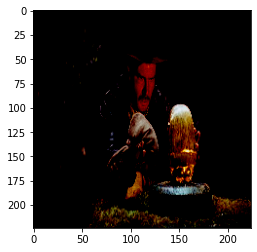

In [16]:
from matplotlib import pyplot
pyplot.imshow(X_train[7])

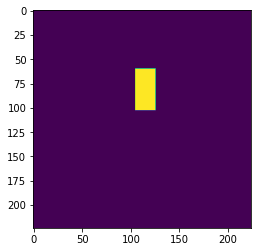

In [17]:
pyplot.imshow(masks[7])

In [18]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
HEIGHT_CELLS = 28
WIDTH_CELLS = 28
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet") # Load pre-trained mobilenet
    for layer in model.layers:
        layer.trainable = trainable

     
    block0 = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)

# Calling the Create Model Function

In [19]:
model = create_model(trainable=True)
#print Summary
print(model.summary())

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
_____________________________

# Defining Dice Coeeficient Function


In [20]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tensorflow.keras.backend.epsilon())

# Defining Loss Function

In [21]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

# Compiling the model

In [22]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

Fit the model with 50 epochs

In [25]:
model.fit(X_train, masks, epochs=5, batch_size=1, verbose=1,callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/5
409/409 [==============================] - 444s 1s/step - loss: 0.9423 - dice_coefficient: 0.5642

Epoch 00001: loss improved from inf to 0.94233, saving model to model-0.94.h5
Epoch 2/5
409/409 [==============================] - 443s 1s/step - loss: 0.6890 - dice_coefficient: 0.6503

Epoch 00002: loss improved from 0.94233 to 0.68905, saving model to model-0.69.h5
Epoch 3/5
409/409 [==============================] - 443s 1s/step - loss: 0.5739 - dice_coefficient: 0.6969

Epoch 00003: loss improved from 0.68905 to 0.57394, saving model to model-0.57.h5
Epoch 4/5
409/409 [==============================] - 442s 1s/step - loss: 0.5221 - dice_coefficient: 0.7181

Epoch 00004: loss improved from 0.57394 to 0.52206, saving model to model-0.52.h5
Epoch 5/5
409/409 [==============================] - 443s 1s/step - loss: 0.4928 - dice_coefficient: 0.7314

Epoch 00005: loss improved from 0.52206 to 0.49279, saving model to model-0.49.h5


As the model was taking a lot of time to get trained, I kept it to 5 epochs. The Dice coefficient after 0.7314 which depicts probability of the similarity of the images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


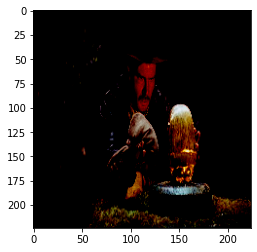

In [27]:
n=7
sample_image = X_train[n]
pyplot.imshow(sample_image)

Imposing the Mask on the image

In [28]:
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


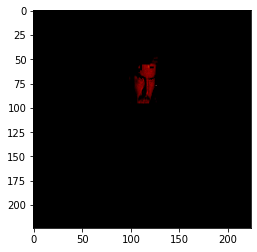

In [29]:
image2 = sample_image
image2[:,:,0] = pred_mask*sample_image[:,:,0]
image2[:,:,1] = pred_mask*sample_image[:,:,1]
image2[:,:,2] = pred_mask*sample_image[:,:,2]

out_image = image2

pyplot.imshow(out_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


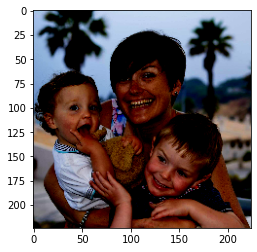

In [30]:
n = 400
sample_image = X_train[n]

pyplot.imshow(sample_image)

In [31]:
pred_mask = cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


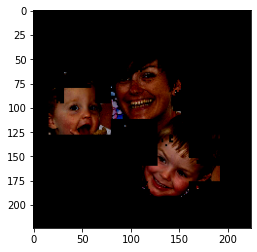

In [32]:
image2 = sample_image
image2[:,:,0] = pred_mask*sample_image[:,:,0]
image2[:,:,1] = pred_mask*sample_image[:,:,1]
image2[:,:,2] = pred_mask*sample_image[:,:,2]

out_image = image2

pyplot.imshow(out_image)